In [12]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
import scipy

from scipy.optimize import curve_fit
from IPython.display import display, Latex
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

# Code

## 1) Looking at the data

In [3]:
data = np.load('../solutions/transient.npy')
data.shape

(100, 3)

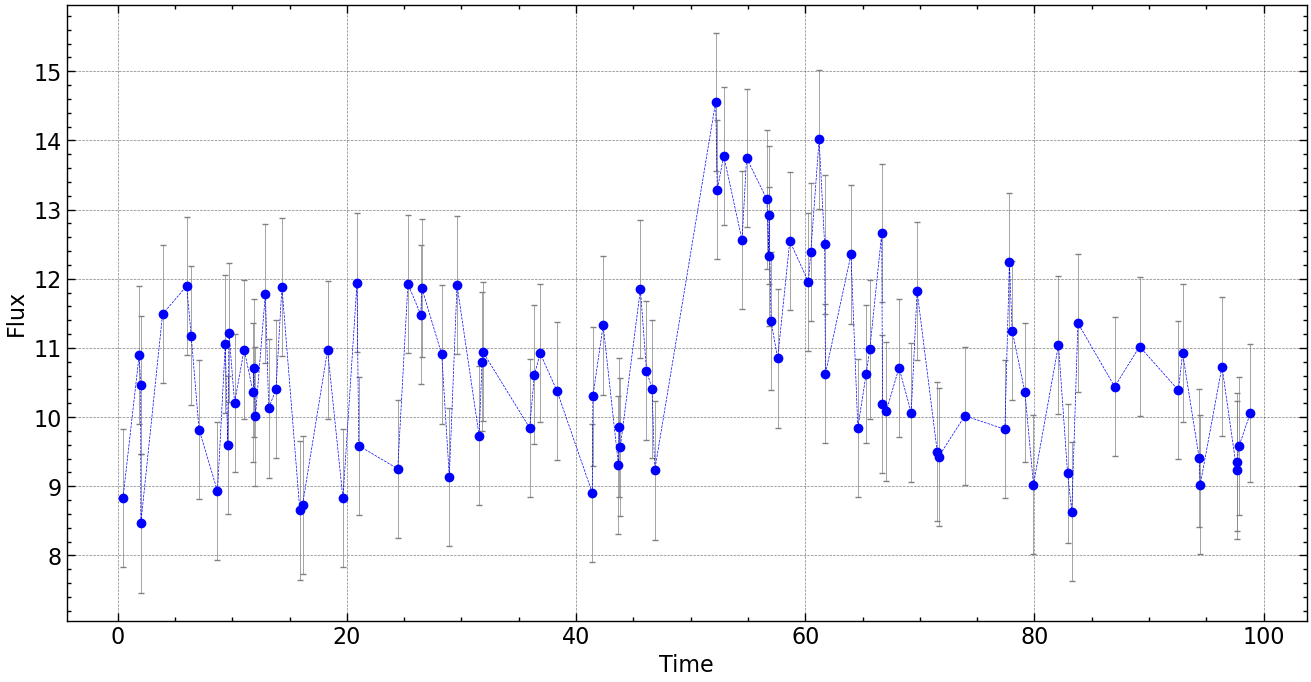

In [4]:
fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5)
plt.xlabel('Time')
plt.ylabel('Flux');

In [5]:
print(f'y_err = {data[:,2]}')

y_err = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


The uncertainties are homoschedastic.

## 2) Defining the model

We want to describe the data according to the following model:

$f(t \,|\, b, A, \alpha, t_0) = 
\begin{cases}
      b & for \:\: t < t_0 \\
      b + Ae^{-\alpha(t-t_0)} & for \:\: t \geq t_0
\end{cases}$

In [6]:
def model(x, b, A, alpha, t0):
    return np.piecewise(x, [x < t0, x >= t0], [lambda x: b, lambda x: b + A*np.exp(-alpha*(x-t0))])

Let's try to fit this model to the data:

b = 10.29 , A = 5.50,  alpha = 0.12 , t0 = 49.08


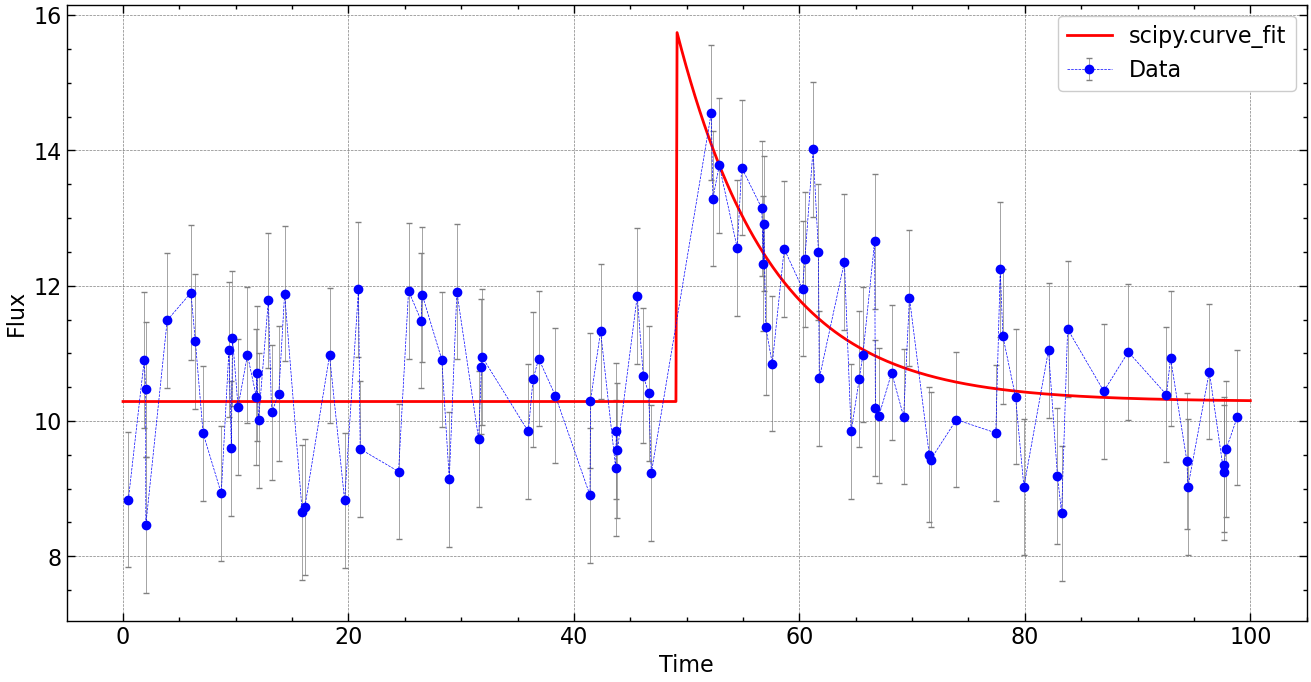

In [7]:
popt, pcov = curve_fit(model, data[:,0], data[:,1], sigma=data[:,2], p0=(10, 4, 0.05, 50), absolute_sigma=True)
print(f'b = {popt[0]:.2f} , A = {popt[1]:.2f},  alpha = {popt[2]:.2f} , t0 = {popt[3]:.2f}')

fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red', label='scipy.curve_fit')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend();

## 3.1) Computing the log-likelihood

Let's assume a gaussian likelihood. Since we have homoschedastic uncertainties, then we can compute it as follows:

$$L(b, A, \alpha, t_0 \,|\, \{t_i\}, \{y_i\}, \sigma) = \prod_{i=1}^{N} \dfrac{1}{\sigma \sqrt{2\pi}} \, exp\left\{-\dfrac{[y_i - f(t_i \,|\, b, A, \alpha, t_0)]^2}{2\sigma^2}\right\}$$

$$\ln\left[L(b, A, \alpha, t_0 \,|\, \{t_i\}, \{y_i\}, \sigma)\right] = \ln\left({ \dfrac{1}{\sigma \sqrt{2\pi}}}\right) - \sum_{i=1}^{N} \dfrac{[y_i - f(t_i \,|\, b, A, \alpha, t_0)]^2}{2\sigma^2}$$

In [8]:
def LogLikelihood(params, data_x, data_y, data_yerr):
    model_y = model(x=data_x, b=params[0], A=params[1], alpha=params[2], t0=params[3])
    return np.log(1/(data_yerr*np.sqrt(2*np.pi))) - np.sum(0.5*np.square((data_y - model_y)/data_yerr))

LogLikelihood(popt, data[:,0], data[:,1], data[:,2])

-48.75225893896217

## 3.2) Computing the prior and the log-posterior

$b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

$p(\ln\alpha) = \dfrac{1}{R - L} \:\: \Longrightarrow \:\: p(\alpha) = p(e^{\ln\alpha}) = \left|\dfrac{d\ln\alpha}{d\alpha}\right| p(\ln\alpha) = \dfrac{p(\ln\alpha)}{\alpha} = \dfrac{1}{\alpha(R - L)}$

In [ ]:
t0min, t0max = 0, 100
Amin, Amax = 0, 50
bmin, bmax = 0, 50
alphamin, alphamax = np.exp(-5), np.exp(5)
sigmaWmin, sigmaWmax = np.exp(-2), np.exp(2)

In [9]:
def Prior(params):
    b, A, alpha, t0 = params
    if ((0 <= b <= 50) and (0 <= A <= 50) and (np.exp(-5) <= alpha <= np.exp(5)) and (0 <= t0 <= 100)):
        return 1/50 + 1/50 + 1/(alpha*(5+5)) + 1/100
    return 0.

def ptform(u, model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [10]:
def LogPosterior(params, data_x, data_y, data_yerr):
    return LogLikelihood(params, data_x, data_y, data_yerr) + np.log(Prior(params))

## 4) Nested sampling with `dynesty`

In [ ]:
ndim = 4

In [ ]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, Prior, ndim)
sampler.run_nested()
results = sampler.results

## 5) Corner plot

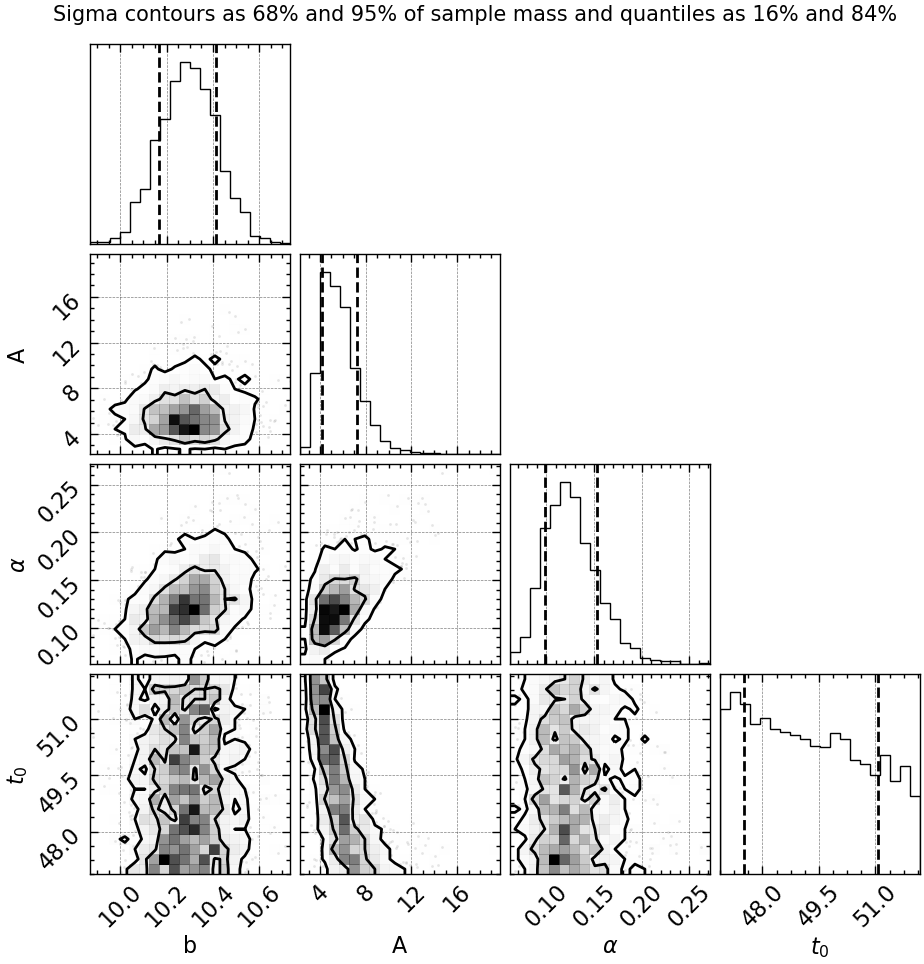

In [19]:
import corner

fig = corner.corner(results, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','$\\alpha$', '$t_0$'])
fig.suptitle("Sigma contours as 68% and 95% of sample mass and quantiles as 16% and 84%", fontsize=15, y=1);

## 6) Time-series plot

In [20]:
samples = results[np.random.choice(len(results), size=100)]
samples.shape

(100, 4)

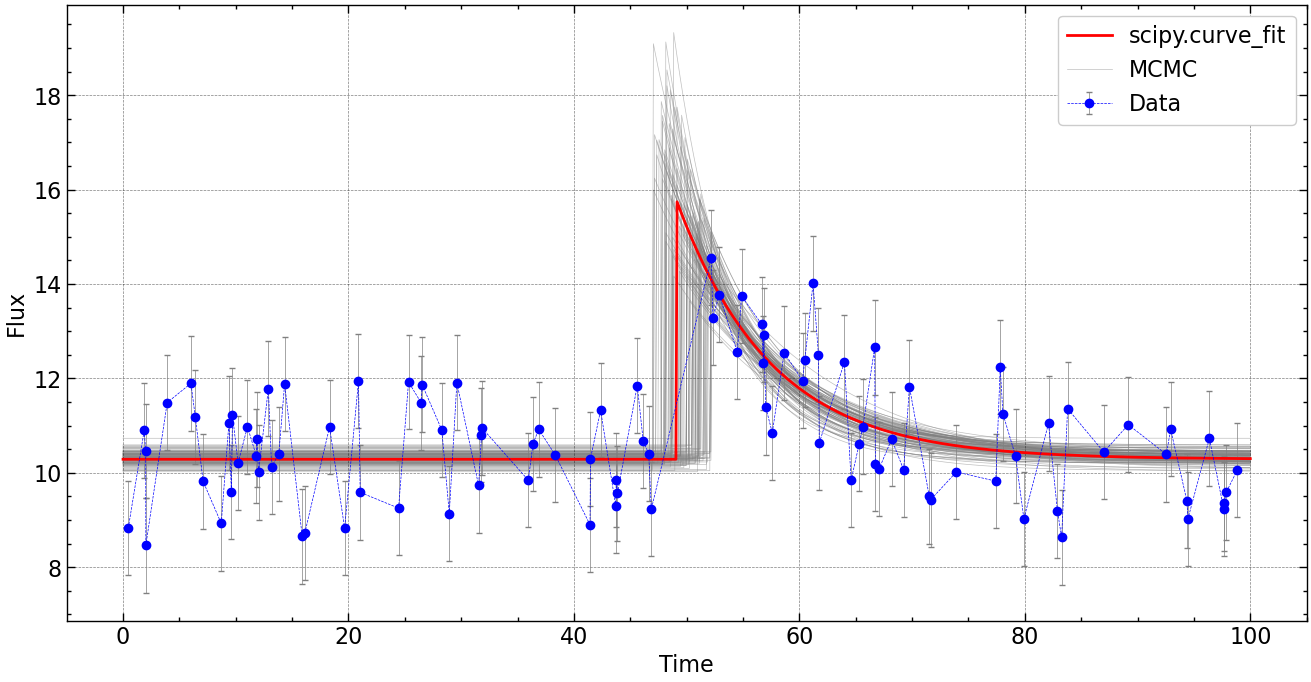

In [21]:
fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red', label='scipy.curve_fit')
plt.xlabel('Time')
plt.ylabel('Flux')

for sample in samples:
    if np.array_equal(sample, samples[0]) : plt.plot(x_dense, model(x_dense, sample[0], sample[1], sample[2], sample[3]), color='grey', lw=0.5, alpha=0.5, label='MCMC', zorder=0)
    plt.plot(x_dense, model(x_dense, sample[0], sample[1], sample[2], sample[3]), color='grey', lw=0.5, alpha=0.5, zorder=0)
    
plt.legend()

## 7) Median and credible region of each parameter

In [25]:
statistics_b = np.percentile(results[:,0], [5, 50, 95]) 
display(Latex(f'$\Large b = {statistics_b[1]:.2f}^{{+{statistics_b[2]-statistics_b[1]:.2f}}}_{{-{statistics_b[1]-statistics_b[0]:.2f}}}$'))

statistics_A = np.percentile(results[:,1], [5, 50, 95]) 
display(Latex(f'$\Large A = {statistics_A[1]:.2f}^{{+{statistics_A[2]-statistics_A[1]:.2f}}}_{{-{statistics_A[1]-statistics_A[0]:.2f}}}$'))

statistics_alpha = np.percentile(results[:,2], [5, 50, 95]) 
display(Latex(f'$\Large \\alpha = {statistics_alpha[1]:.2f}^{{+{statistics_alpha[2]-statistics_alpha[1]:.2f}}}_{{-{statistics_alpha[1]-statistics_alpha[0]:.2f}}}$'))

statistics_t0 = np.percentile(results[:,3], [5, 50, 95]) 
display(Latex(f'$\Large t_0 = {statistics_t0[1]:.2f}^{{+{statistics_t0[2]-statistics_t0[1]:.2f}}}_{{-{statistics_t0[1]-statistics_t0[0]:.2f}}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

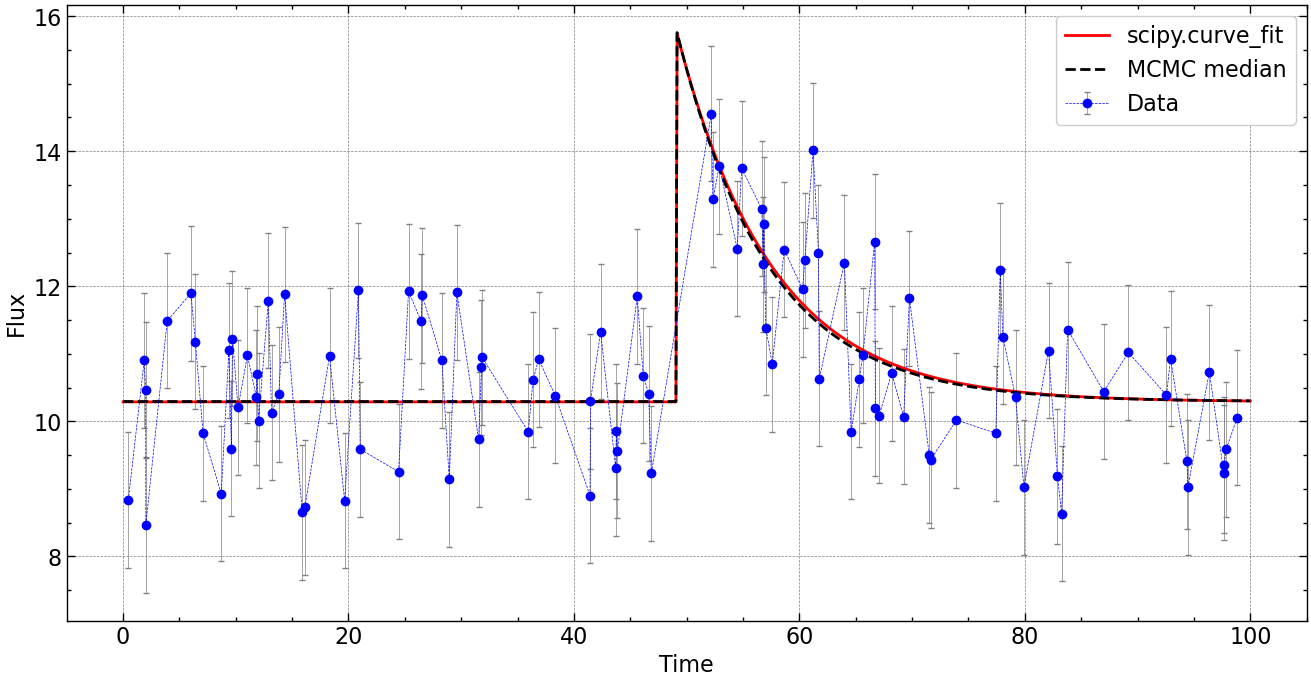

In [31]:
# Pick the maximum a posteriori instead

fig = plt.figure(figsize=(16, 8))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, ls='--', lw=0.5, label='Data')
x_dense = np.linspace(0, 100, 1000)
plt.plot(x_dense, model(x_dense, popt[0], popt[1], popt[2], popt[3]), color='red', label='scipy.curve_fit')
plt.plot(x_dense, model(x_dense, statistics_b[1], statistics_A[1], statistics_alpha[1], statistics_t0[1]), color='black', ls='--', label='MCMC median')
plt.xlabel('Time')
plt.ylabel('Flux') 
plt.legend()